Start by importing all the modules you will need

In [180]:
import tensorflow as tf

import numpy as np # useful to have
%matplotlib inline 
# Above line Needed for juypter only
from matplotlib import pyplot as plt
import pandas as pd

print("Tensorflow version : ", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("GPU visible",end=" ")
    if tf.test.is_built_with_cuda():
        print("-> GPU enabled")
else:
    print("GPU not visible")

Tensorflow version :  2.13.1
GPU not visible


# Keras and Tensorflow

Keras is a high level API for machine learning, Tensorflow is built on top of keras so it can be used more easily in python

GPU is not supported as of Tensorflow 2.10 for windows, however you can build a virtual enviroment/docker. 
- I will not explain virtualisation here as the CPU is more than enough for this task.


# Tensorflow site:

https://www.tensorflow.org/

This notebook follows the beginner quickstart guide however the steps involved are explained much further.

https://www.tensorflow.org/tutorials/quickstart/beginner



# Data

The data we will be using is a series of hand drawn images of numbers 0 to 9, Each image is labeled with its correct answer so the model can improve its results. Tensorflow/keras comes with this dataset and others already but you can get it here as well

http://yann.lecun.com/exdb/mnist/

We seperate out two sets of data for neural networks, this sepeation should be random to avoid bias
- Training data
    - this is the larger set and the model weights will be trained using this
- Testing data
    - we use a test dataset to see both how it performs with data it has never seen before and how it compares to previous versions of itself. This is how we can be certain that the model is learning and not memorising.

When training the model we give it the image in the form of a matrix and it has to guess what that image represents, it makes this guess using the output layer, the output is in the form of a probability or confidence, we consider the highest value in the final layer as it's answer in most cases.

A data is often the limiting factor of machine learning models, it needs to be very large, varied and accurately labeled to train a good model. If there is too little data or the data does not have enough variation the model wont be able to find patterns properly and will just overfit to the dataset

In [159]:
mnist_data = tf.keras.datasets.mnist
(train_images, train_label), (test_images, test_label) = mnist_data.load_data()
# Scale the intergers to values between 0 and 1, this helps remove any biases.
# for example 5 is drawn with only values of 255 but 6 is drawn with only values of 1, the model may pick up on this and base its decision entirely on the value of pixels instead taking into account other factors
train_images = train_images / 255 
test_images = test_images / 255
# (train_images, train_label) = (train_images[:100], train_label[:100]) # A Lower training sample leads to overfitting and it will not be accurately determine the test data
# overfitting should be avoided at all costs

print("Training data size : ", f"{train_label.shape[0]:,}")
print("Test data size     : ", f"{test_label.shape[0]:,}")

Training data size :  60,000
Test data size     :  10,000


We can represent what the network sees by putting the values in a grid

The data is a 28x28 matrix with numbers now ranging from 0 to 1. We can plot each point on a graph as a pixel

Use `sample_image_index` to change the image shown below

Image label : 5


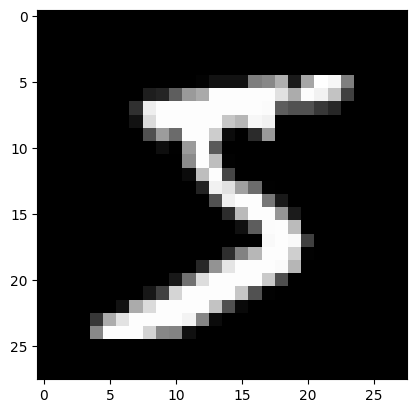

In [195]:
sample_image_index = 0

plt.imshow(train_images[sample_image_index],cmap="grey")
# cmap changes the colour scheme, but keep in mind that the model has no perception of colour, only the value of each pixel in the grid.
print("Image label :", train_label[sample_image_index])

# The Machine learning model

Neural networks generate their answers by passing the data through its layers, each node multiplies the previous node's output by a weight then adds a bias. This is then passed through an activation function to scale it between a set range of values and to smooth the output. The activation function can have an effect on the accuracy of the model so its best to try a few.

input layer -> hidden layer(s) -> output layer

The Input layer are the first layer of a network and is where the data starts, in this example it is a list of all the pixels of the input image

Hidden layers vary in number of nodes and amount of layers, the more layers it has the more complex functions it can make but it will become more expensive to computate, the number of nodes helps provide more information to the next layer. There is no science behind the number and layers of nodes to have. Consider the hidden layers as the capacity of a network to learn more complex functions

The Output layer should contain all the possible outputs you expect, in our case it is values 0 to 9, these values are used determine what the network has decided to catagorise the input by taking the largest value. The output is also used to calculate the loss/cost (how far it is from being correct) and accuracy (correct predictions out of total predictions).

Initialise a model with the code below

In [161]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

The model we initialised is a Sequential model, data is passed through each layer at a time, it is one of the more basic neural network structures

The order of the layers matter

- tf.keras.layers.Flatten()
    - Input layer, flattens the input numpy array to be a list with length 784 (28 * 28)
- tf.keras.layers.Dense(x, activation="relu")
    - this adds a layer of x nodes with an activation function
- tf.keras.layers.Dropout()
    - randomly sets the previous input value to zero to help prevent overfitting, it is a fraction of the nodes to turn off (the node turned off is random but the amount of nodes turned off is not)
- tf.keras.layers.Dense(x)
    - This final layer is the output and should be the size of the expected outputs

Below code takes the sample data point, of our dataset, and passes it through the model to predict what it is, the model has been initialised with random weights so the answers are all mostly wrong

In [162]:
predictions = model.predict(train_images[[sample_image_index]])
# soft max scales the values between 0 and 1 with the constraint that the sum is equal to 1
probablities = tf.nn.softmax(predictions).numpy()
# This gets us the probability/confidence

d = {index : round(confidence,4) for index, confidence in zip(range(10), probablities[0])}
print("Network Answer :", max(d,key=lambda x : d[x]))
print("Actual Answer  :", train_label[sample_image_index])
# Weights are randomly selected so it may get one or two right by pure chance
print("Confidence levels : ")
d

1/1 [==============================] - 0s 34ms/step
Network Answer : 4
Actual Answer  : 5
Confidence levels : 


{0: 0.0735,
 1: 0.0942,
 2: 0.123,
 3: 0.1331,
 4: 0.1688,
 5: 0.0677,
 6: 0.089,
 7: 0.0876,
 8: 0.0629,
 9: 0.1003}

# Loss and cost

Loss and cost in terms of deep learning are the same thing

By taking in all the answers from the output layer, for a single performed input, we can determine how close (or how far) from being correct it is and calculate it's loss (also known as cost). A lower loss is better and also a higher accuracy is better, they are strongly negatively correlated but they are not the inverse of each other. 

From the calculated loss we can do a method called back propagation to adjust the weights and biases for a lower loss.

$$
\text{error}_x = (\text{actual activation})_x - (\text{expected output})_x
$$
$$
\text{node cost}_x = \text{error}_x^2 
$$
$$
\text{total cost} = \sum_{i=1}^\text{n}{(\text{node cost})_i}
$$

Taking the square means all our errors are positive and will not cancel out if we wish to take the average and it magnifies larger errors compared to smaller ones.

This is just one method of calculating the loss. This is the mean squared error and is also used in logistic regression, which you will learn in 4IQT.

```python

# Sample code of above equations
def node_cost(output_activation, expected_output):
    error = output_activation - expected_output
    return error ** 2

total_cost = 0

for output_index in range(len(model.output_layer)):
    output = model(train_image[output_index])
    total_cost += node_cost(output[output_index], train_label[output_index])

```

We can define the loss function as a variable or model.compile will find it for us if we pass use 
```python
loss="SparseCategoricalCrossentropy"
``` 

In [163]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

 We can find the loss value for the first data point by using below code 

In [164]:
loss_function(train_label[:1], predictions).numpy()

2.6933181

Before training the model we need to compile it, the optimizer is an algorithim which determines how to reduce loss. It is also known as Back propagation.


Other optimizers here : https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

Back propagation is very math heavy and involves multivariable calculus.

More information here : http://neuralnetworksanddeeplearning.com/chap2.html

In [165]:
model.compile(optimizer="adam", loss=loss_function, metrics=["accuracy"])

Now we can train the model using the data, One epoch means the model has seen every image in the training data once. Iterating this step improves accuracy.

A Batch is the amount images handed to the model before adjusting its weights. Adjusting weights too soon can be bad should the model recieve multiple of the same in the row. The order of input does effect the neural network but this dataset is meant to be unordered as the previous result does not effect the next.

An epoch too low results in a poor accuracy, but a high epoch will take more time and will also need more data to avoid overfitting. Additionally training has a diminishing return on accuracy with the largest jumps of accuracy occuring first then rapidly decreasing after.

In [166]:
history = model.fit(train_images, train_label,epochs=5)
# model.fit returns the history of training over the epochs to save later

Epoch 1/5
1875/1875 [==============================] - 2s 803us/step - loss: 0.4628 - accuracy: 0.8648
Epoch 2/5
1875/1875 [==============================] - 2s 811us/step - loss: 0.2737 - accuracy: 0.9186
Epoch 3/5
1875/1875 [==============================] - 2s 821us/step - loss: 0.2353 - accuracy: 0.9281
Epoch 4/5
1875/1875 [==============================] - 2s 830us/step - loss: 0.2149 - accuracy: 0.9361
Epoch 5/5
1875/1875 [==============================] - 2s 808us/step - loss: 0.2029 - accuracy: 0.9374


Note that in juypter the more times you run the cell above the more accurate it gets, this is becuase it is updating the model object everytime and juypter keeps the model object in memory loaded.

If you want to reset the results then re-run the cell where `model` was initialized.

Finally we evaluate our model with the test data, since we are not training it we dont have to iterate over it.

In [167]:
test_loss, test_accuracy = model.evaluate(test_images, test_label, verbose=2)
# model.evaluate() returns an array in form [cost, accuracy]

313/313 - 0s - loss: 0.1376 - accuracy: 0.9590 - 275ms/epoch - 878us/step


 The more we train the model the more accurate it becomes against the test set, however there is an upper limit to the model in its current state. To get a higher accuracy on the test data we can:
 - Adjust epochs
 - Adjust nodes
 - Adjust layers
 - Improve training data with more variation or more accurate labels
 - Change batch size
 - Use other activation functions
 - Change dropout rate
 - Use other back propagation functions
 - Use other types of nodes
 - Use Pre-processing

A more complex network will mean it will take longer to train as there is more to calculate, there is no equation for calculating the network size, shape or even optimal amount of epochs for a specific problem so its a matter of trial and error

Also you need to re-train it everytime you adjust it.

# Overfitting and model performance

Accuracy increases over epochs, the more it is trained the better it becomes. However the more epochs the model goes over, the more information about the training data is leaked into the model. Over time this causes overfitting, the model begins memorising the data instead of looking for patterns, overfitting occurs sooner for smaller and less varied datasets. 

We can look for overfitting by using the test data and comparing it to the training data, a drop in accuracy and spike in cost generally means it is overfitted. 

- A spike in cost means that it is less confident on its final answers
- A drop in accuracy is because the model has memorised the training data instead of learning patterns, An overfitted model can still be accurate so it is important to use cost as well

However no spike also suggests that the model has likely not been trained enough and it can still figure out a lower cost function.

The speed of a network depends on its size, larger more complex models require more memory, data and calculations.

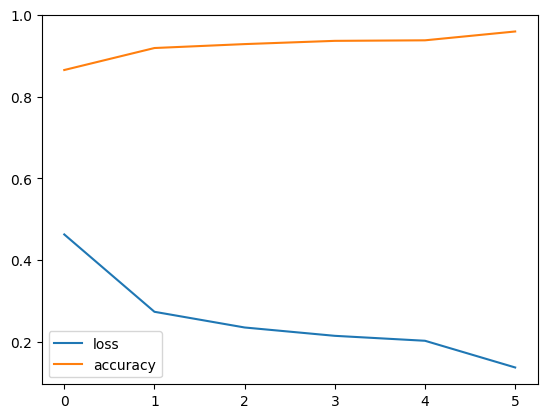

In [168]:
data = pd.DataFrame(history.history)
data.loc[len(data)] = (test_loss, test_accuracy)

plt.plot(data)
plt.legend(data.columns)

Using pandas we can save the history directly to csv to copy over into an excel document for further analysis

In [169]:
data.to_csv("Training data.csv")

# Using the model

Instead of training the model everytime we want to use it, we can save the neural network then load it in later. `model.save(file_path)` saves the entire model, even its structure, so we can load it back in using `models.load_model(file_path)`

Make sure to use the extention .keras

In [170]:
model.save("mynetwork.keras")
model = tf.keras.models.load_model("mynetwork.keras")

To make predictions we use `model.predict()` and pass in a list of the predictions we want it to make.

In [172]:
predictions = model.predict(test_images[[sample_image_index]])
# soft max scales the values between 0 and 1 with the constraint that the sum is equal to 1
probablities = tf.nn.softmax(predictions).numpy()
# This gets us the probability/confidence

d = {index : round(confidence,4) for index, confidence in zip(range(10), probablities[0])}
print("Network Answer :", max(d,key=lambda x : d[x]))
print("Actual Answer  :", test_label[sample_image_index])
d

1/1 [==============================] - 0s 13ms/step
Network Answer : 7
Actual Answer  : 7


{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0002,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.9998,
 8: 0.0,
 9: 0.0}

Now try and modify either the data or neural network to get as high of an accuracy as possible for the testing data. You can compare to the leaderboard found [here](http://yann.lecun.com/exdb/mnist/)

As a challenge automate the network shape iteration and epoch to find the optimal neural network shape and weights.